In [1]:
# Librerias
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:

IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=50
CHANNELS=3

In [3]:

dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "./train",
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "./test",
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names
class_names

['Benign', 'Malignant']

In [5]:
# Train,validation and Test split

def get_dataset_partitation(ds,train_split=0.8, valid_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + valid_split + test_split == 1)
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(ds_size * train_split)
    test_size = int(ds_size * test_split)
    valid_size = int(ds_size * valid_split)
    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds,valid_ds,test_ds

In [6]:
train_ds,valid_ds,test_ds = get_dataset_partitation(dataset)

In [7]:
# print(len(train_ds))
# print(len(test_ds))
# print(len(valid_ds))

In [24]:
# Optimizar obtencion de datos
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resize and Rescale
resize_and_rescale=tf.keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.Rescaling(1./255)
    ]
)

In [10]:
# Aumento de datos
data_augmentation=tf.keras.Sequential(
   [ layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3)]
)

In [11]:
# Construccion del modelo
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=2,
)

Epoch 1/2
297/297 ━━━━━━━━━━━━━━━━━━━━ 256s 821ms/step - accuracy: 0.6636 - loss: 0.5885 - val_accuracy: 0.8041 - val_loss: 0.4409
Epoch 2/2
297/297 ━━━━━━━━━━━━━━━━━━━━ 216s 727ms/step - accuracy: 0.8008 - loss: 0.4385 - val_accuracy: 0.8218 - val_loss: 0.3834


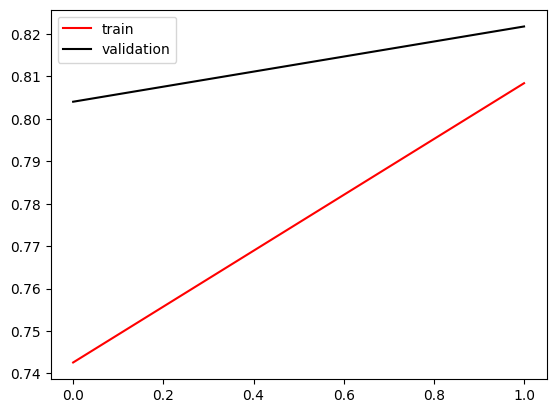

In [14]:
# Model Accuracy Plot
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='black',label='validation')
plt.legend()
plt.show()

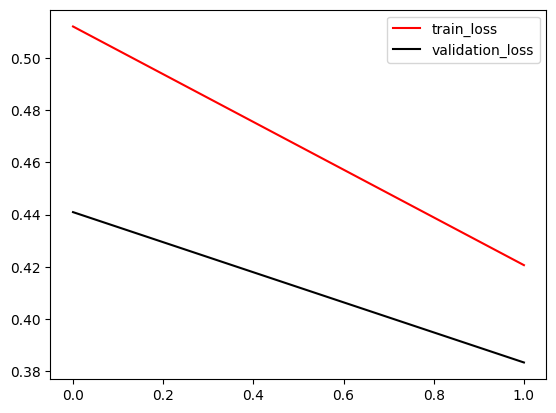

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train_loss')
plt.plot(history.history['val_loss'],color='black',label='validation_loss')
plt.legend()
plt.show()

In [16]:
# Accuracy
scores = model.evaluate(test_ds)
scores_test = model.evaluate(test_dataset)

print(scores)
print(scores_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.8481 - loss: 0.3522
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.8008 - loss: 0.4487
[0.3648720979690552, 0.8379934430122375]
[0.44175583124160767, 0.8019999861717224]


In [17]:
# Predict
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Actual vs Predict Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

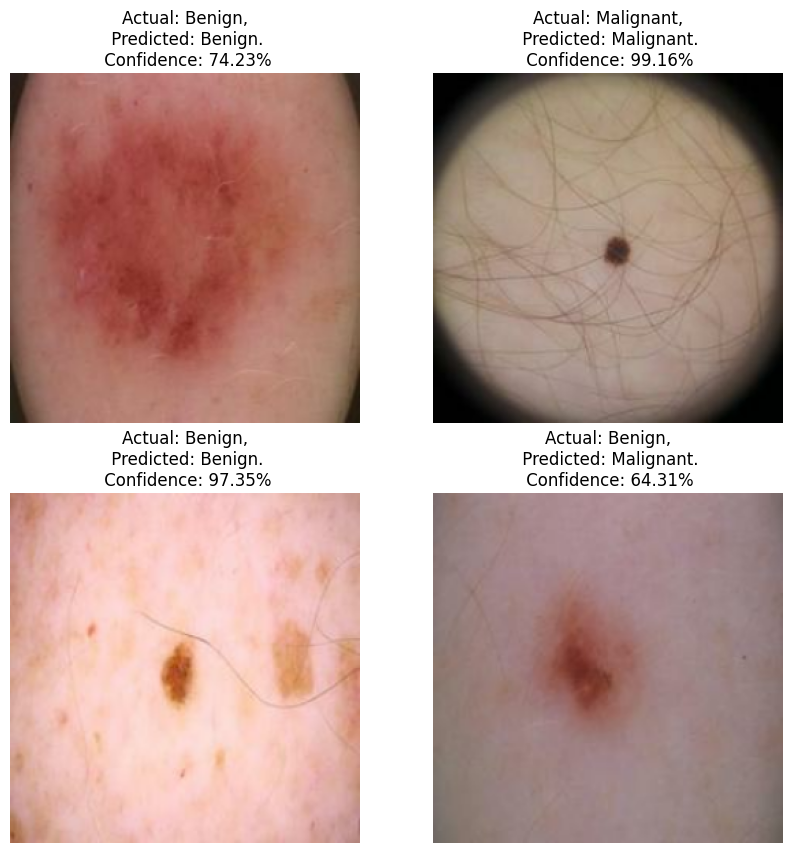

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(10):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")